# <center> HW1 : Speech Recognition

# Part 1

## Set-up

In [3]:
# Download the dataset
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!rm -rf speech_commands
!mkdir speech_commands
!tar -zxf speech_commands_v0.01.tar.gz -C speech_commands

--2020-02-16 22:03:28--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.23.128, 2404:6800:4008:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.23.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  69.9MB/s    in 17s     

2020-02-16 22:03:46 (81.7 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [2]:
import numpy as np
!pip install git+https://github.com/bootphon/spectral.git
!pip install jiwer
import jiwer
import spectral
import librosa
import IPython
import os, glob
import ast
import scipy.io.wavfile as wav
import sklearn
from sklearn.neural_network import MLPClassifier
import time
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random.seed(777)


  Cloning https://github.com/bootphon/spectral.git to /tmp/pip-req-build-spipj3ox
  Running command git clone -q https://github.com/bootphon/spectral.git /tmp/pip-req-build-spipj3ox
  Created wheel for spectral: filename=spectral-0.1.7-cp36-cp36m-linux_x86_64.whl size=63201 sha256=b016be526319a70a3b88c18a073602dc78b140202f5dd62550dc002e2914eb41
  Stored in directory: /tmp/pip-ephem-wheel-cache-ekpx31x6/wheels/73/fd/30/6edc3e8687a96ba559a35ad0de5fa98922066731d716e4c22d
Successfully built spectral


In [0]:
## Helpers for feature extraction
def txt2list(filename):
    lines_list = []
    with open(filename, 'r') as txt:
        for line in txt:
            lines_list.append(line.rstrip('\n'))
    return lines_list

def transform_wavs(wavs_list, feature_func):
    features = []
    for wav in wavs_list:
        features.append(feature_func.transform(wav).flatten())
    return features

def pad(features, max_len=1616):
    padded_features =[]
    for feat_file in features:
        max_len = max(max_len, feat_file.shape[0])
    for feat_file in features:
        pad_size = max_len - feat_file.shape[0]
        left_pad = pad_size // 2
        right_pad = pad_size - left_pad
        padded_features.append(np.pad(feat_file, ((left_pad, right_pad),), 'constant', constant_values=(0, 0)))
    return padded_features

In [5]:
### Access data
path_to_wav = './speech_commands/'
directories_speech_commands = os.listdir(path_to_wav)
directories_speech_commands = [x for x in directories_speech_commands if os.path.isdir(os.path.join(path_to_wav,x))]
directories_speech_commands = [x for x in directories_speech_commands if x != '_background_noise_']
label_set = directories_speech_commands
print('number of labels', len(label_set))
print('Labels', label_set)
nb_ex_per_class = 1000 # To have balance classes for the NN/Logistic Regression
# Valid set
valid_list = txt2list('./speech_commands/validation_list.txt')
# Test set
test_list = txt2list('./speech_commands/testing_list.txt')

number of labels 30
Labels ['stop', 'sheila', 'nine', 'no', 'wow', 'left', 'down', 'eight', 'right', 'four', 'marvin', 'seven', 'yes', 'off', 'up', 'happy', 'five', 'two', 'tree', 'go', 'three', 'dog', 'one', 'house', 'cat', 'on', 'zero', 'bed', 'six', 'bird']


In [8]:
### Build train ,test and validation setts

# Iterate over files
train_wavs = []
train_labels = []

valid_wavs = []
valid_labels = []

test_wavs = []
test_labels = []

start = time.time()

for root, dirs, files in os.walk("speech_commands"):
    if "_background_noise_" in root:
        continue
    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.split("/")[-1]
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root, filename)
        partial_path = '/'.join([command, filename])
        if partial_path in valid_list and len(valid_labels) < 1000:
            fs, waveform = wav.read(full_name)
            valid_wavs.append(waveform)
            valid_labels.append(label)
        elif partial_path in test_list and len(test_labels) < 1000:
            fs, waveform = wav.read(full_name)
            test_wavs.append(waveform)
            test_labels.append(label)
        elif train_labels.count(label) < nb_ex_per_class:
            fs, waveform = wav.read(full_name)
            train_wavs.append(waveform)
            train_labels.append(label)
# Print data statistics

print("Train files:" + str(len(train_wavs)))
print("Valid files:" + str(len(valid_wavs)))
print("Test files:" + str(len(test_wavs)))

end = time.time()

print("Time to output features: " + str(end-start))

Train files:30000
Valid files:1000
Test files:1000
Time to output features: 22.383050203323364


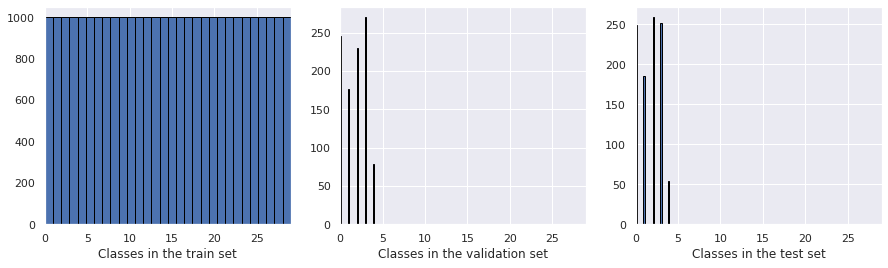

In [9]:
### class repartition between train, test and validation
sns.set()

f, axs = plt.subplots(1, 3, figsize = (15,4))
axs[0].hist(train_labels, bins=30, color='C0', density=False, ec='black', )
axs[0].set_xlim(0,29)
axs[0].set_xlabel('Classes in the train set')
axs[1].hist(valid_labels, bins=30, color='C0', density=False, ec='black', )
axs[1].set_xlim(0,29)
axs[1].set_xlabel('Classes in the validation set')
axs[2].hist(test_labels, bins=30, color='C0', density=False, ec='black', )
axs[2].set_xlim(0,29)
axs[2].set_xlabel('Classes in the test set')
plt.savefig('plot.eps', bbox_inches='tight')
plt.show()

In [0]:
#### NN implementation using keras:

#Deep learning
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation,Convolution1D,MaxPooling1D,Flatten,BatchNormalization,Dropout

In [0]:
import logging
logging.getLogger('tensorflow').disabled = True

In [12]:
# Initial application of the MFCC
mfcc = spectral.Spectral(nfilt=20,ncep=8,
                    do_dct=True,
                    lowerf=0,
                    upperf=7000,
                    alpha=0.6,
                    fs=16000,
                    frate=100,
                    wlen=0.02,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end=time.time()
print('finished in ',end-start)

nb_of_categories=len(label_set)

all_labels = train_labels + valid_labels+ test_labels 
all_labels_cat = to_categorical(all_labels,nb_of_categories)

train_labels_cat = all_labels_cat[:len(train_labels)]
valid_labels_cat = all_labels_cat[len(train_labels):len(train_labels)+len(valid_labels)]
test_labels_cat = all_labels_cat[-len(test_labels):]



finished in  167.99918174743652


In [0]:
## Define an initial model 
def load_base_model():
  mcp = ModelCheckpoint('weights.best.hdf5', monitor="val_acc",
                      save_best_only=True, save_weights_only=False)
  model = Sequential()

  model.add(Convolution1D(50,5,input_shape=(train_feats.shape[1],1,)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Convolution1D(20,3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling1D(2))
  model.add(Dropout(0.3))
  model.add(Convolution1D(40,4))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Convolution1D(20,3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling1D(2))
  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(nb_of_categories,activation='softmax'))

  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc'])

  base_model = model
  return base_model,mcp

## **Question 1.1:** 

Study the influence of the frequency range, hyper-parameter for the MFCC, on the validation performance. Choose only one model for this study. Does it concord with what we know about human speech characteristics (see material chap 7.5 Jurafsky ed 2) and sampling limitations of a continuous signal?

In [0]:
# Range definition : Audibale range
lowerf_list=[0,20,50,100]
upper_list=[5000,7000,8000]
framerate = 16000
wlen = 0.02 # changed the default value
val_scores=dict()
n_epochs = 50

In [0]:
# Hyperparmeters tuning
for lower in lowerf_list:
  for upper in upper_list:
      print('frequency_range ',(lower,upper))
      mfcc = spectral.Spectral(nfilt=20,ncep=8,
                    do_dct=True,
                    lowerf=lower,
                    upperf=upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=wlen ,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)
      feature_function = mfcc

      start = time.time()
      train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
      valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
      test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
      print('Compute categarical features')
      train_feats2 = train_feats.reshape(train_feats.shape[0],-1,1)
      valid_feats2 = valid_feats.reshape(valid_feats.shape[0],-1,1)
      test_feats2 = test_feats.reshape(test_feats.shape[0],-1,1) 

      model,mcp = load_base_model()
      end = time.time() 
      print("Time to output features: " + str(end-start))
      start = time.time()
      history= model.fit(train_feats2,train_labels_cat,validation_data=(valid_feats2,valid_labels_cat),epochs=n_epochs,batch_size=32,callbacks=[mcp])
      end = time.time() 
      print("Time to output features: " + str(end-start))
      score = model.evaluate(test_feats2, test_labels_cat)
      print('NN network score', score)
      print("Training time: " + str(end-start))
      val_scores[str(lower)+','+str(upper)]= score

frequency_range  (100, 7000)
Compute categarical features
Time to output features: 182.29924941062927
Train on 30000 samples, validate on 1000 samples
Epoch 1/50
30000/30000 [==============================] - 30s 1ms/step - loss: 2.7452 - acc: 0.2328 - val_loss: 2.3774 - val_acc: 0.2280
Epoch 2/50
30000/30000 [==============================] - 14s 466us/step - loss: 1.8851 - acc: 0.4681 - val_loss: 1.7904 - val_acc: 0.4690
Epoch 3/50
30000/30000 [==============================] - 14s 477us/step - loss: 1.5918 - acc: 0.5402 - val_loss: 1.6996 - val_acc: 0.5140
Epoch 4/50
30000/30000 [==============================] - 14s 465us/step - loss: 1.4306 - acc: 0.5853 - val_loss: 1.3619 - val_acc: 0.6150
Epoch 5/50
30000/30000 [==============================] - 14s 473us/step - loss: 1.3369 - acc: 0.6143 - val_loss: 1.3387 - val_acc: 0.5960
Epoch 6/50
30000/30000 [==============================] - 14s 467us/step - loss: 1.2645 - acc: 0.6312 - val_loss: 1.1283 - val_acc: 0.6740
Epoch 7/50
30000/


**Results of finetuning of the range =** (50,7000)


In [0]:
# collect best bounds based on previous finetuning
best_lower = 100
best_upper = 8000
framerate=16000
mfcc1 = spectral.Spectral(nfilt=20,ncep=8,
                    do_dct=True,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=wlen,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)

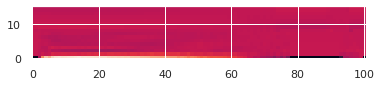

In [0]:
### Visualization of the best result on a random wave
random_idx = random.randint(0, len(valid_wavs))
random_wav = valid_wavs[random_idx]
IPython.display.Audio(random_wav, rate=16000)
plt.imshow(mfcc1.transform(random_wav).transpose())
plt.gca().invert_yaxis()

## **Question 1.2:** 

Study the influence of the number of filters for the mel-log filterbanks and the number of cepstral coefficient for the MFCC, on the validation performance. Choose only one model for this study.
Interpret this result with what you saw in class.

##### **MFCC**

In [0]:
ncep_list=[8,9,10,12,13]
best_lower = 100
best_upper = 8000
framerate=16000
framerate = 16000
wlen = 0.02 # changed the default value
val_scores=dict()
n_epochs = 50

In [0]:
for ncep in ncep_list:
  
      print('ncep ',ncep)
      mfcc = spectral.Spectral(nfilt=20,ncep=ncep,
                    do_dct=True,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=wlen ,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)
      feature_function = mfcc

      start = time.time()
      train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
      valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
      test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
      print('Compute categarical features')
      train_feats2 = train_feats.reshape(train_feats.shape[0],-1,1)
      valid_feats2 = valid_feats.reshape(valid_feats.shape[0],-1,1)
      test_feats2 = test_feats.reshape(test_feats.shape[0],-1,1) 

      model,mcp = load_base_model()
      end = time.time() 
      print("Time to output features: " + str(end-start))
      start = time.time()
      history= model.fit(train_feats2,train_labels_cat,validation_data=(valid_feats2,valid_labels_cat),epochs=n_epochs,batch_size=32,callbacks=[mcp])
      end = time.time() 
      print("Time to output features: " + str(end-start))
      score = model.evaluate(test_feats2, test_labels_cat)
      print('NN network score', score)
      print("Training time: " + str(end-start))
      val_scores[str(ncep)]= score

In [0]:
val_scores

{'10': [0.9680891762971878, 0.762],
 '12': [1.0989800670146943, 0.734],
 '13': [1.0873877167701722, 0.737],
 '8': [1.0769129557609558, 0.714],
 '9': [0.8595851333141327, 0.772]}

In [0]:
best_ncep = 9

##### **Mel-log filterbanks**

In [0]:
# Tuning on Filter numbers
nfilt_list=[80]
val_scores_melfb =dict()

for filt in nfilt_list:
  
      print('filt ',filt)
      melfbanks = spectral.Spectral(nfilt=filt,
                    ncep=0,
                    do_dct=False,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.5,
                    fs=framerate,
                    frate=100,
                    wlen=wlen,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)
      feature_function = melfbanks

      start = time.time()
      train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
      valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
      test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
      print('Compute categarical features')
      train_feats2 = train_feats.reshape(train_feats.shape[0],-1,1)
      valid_feats2 = valid_feats.reshape(valid_feats.shape[0],-1,1)
      test_feats2 = test_feats.reshape(test_feats.shape[0],-1,1) 

      model,mcp = load_base_model()
      end = time.time() 
      print("Time to output features: " + str(end-start))
      start = time.time()
      history= model.fit(train_feats2,train_labels_cat,validation_data=(valid_feats2,valid_labels_cat),epochs=n_epochs,batch_size=32,callbacks=[mcp])
      end = time.time() 
      print("Time to output features: " + str(end-start))
      score = model.evaluate(test_feats2, test_labels_cat)
      print('NN network score', score)
      print("Training time: " + str(end-start))
      val_scores_melfb[filt]= model.evaluate(test_feats2, test_labels_cat) 

filt  80
Compute categarical features
Time to output features: 444.6990797519684
Train on 30000 samples, validate on 1000 samples
Epoch 1/50
30000/30000 [==============================] - 61s 2ms/step - loss: 2.4426 - acc: 0.3273 - val_loss: 1.8448 - val_acc: 0.4500
Epoch 2/50
30000/30000 [==============================] - 45s 1ms/step - loss: 1.5725 - acc: 0.5545 - val_loss: 1.3628 - val_acc: 0.5910
Epoch 3/50
30000/30000 [==============================] - 45s 2ms/step - loss: 1.2264 - acc: 0.6448 - val_loss: 1.3236 - val_acc: 0.6100
Epoch 4/50
30000/30000 [==============================] - 45s 2ms/step - loss: 0.9939 - acc: 0.7108 - val_loss: 1.2650 - val_acc: 0.6190
Epoch 5/50
30000/30000 [==============================] - 45s 1ms/step - loss: 0.8213 - acc: 0.7581 - val_loss: 1.3190 - val_acc: 0.6070
Epoch 6/50
30000/30000 [==============================] - 45s 2ms/step - loss: 0.6878 - acc: 0.7939 - val_loss: 1.2334 - val_acc: 0.6230
Epoch 7/50
30000/30000 [========================

##**Question 1.3:** 

Study the influence of the delta and delta_delta for the MFCC, on the validation performance. Choose only one model for this study.
Interpret and comment this result.

In [0]:
deltas=[True, False]
val_scores=dict()
for delta in deltas:
    print('delta used =',delta)
    mfcc = spectral.Spectral(nfilt=20,ncep=best_ncep,
                    do_dct=True,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen = wlen,
                    nfft=512,
                    compression='log',
                    do_deltas=delta,
                    do_deltasdeltas=False)
    feature_function = mfcc

      
    start = time.time()
    train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
    valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
    test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
    end = time.time() 
    print("Time to output features: " + str(end-start))
    
    train_feats2 = train_feats.reshape(train_feats.shape[0],-1,1)
    valid_feats2 = valid_feats.reshape(valid_feats.shape[0],-1,1)
    test_feats2 = test_feats.reshape(test_feats.shape[0],-1,1)

    model,mcp = load_base_model()
    start = time.time()
    history= model.fit(train_feats2,train_labels_cat,validation_data=(valid_feats2,valid_labels_cat),epochs=n_epochs,batch_size=32,callbacks=[mcp])
    print('NN network score',model.evaluate(test_feats2, test_labels_cat))
    end = time.time()
    print("Training time: " + str(end-start))

    val_scores[delta]= model.evaluate(test_feats2, test_labels_cat)

delta used = True
Time to output features: 261.6081118583679
Train on 30000 samples, validate on 1000 samples
Epoch 1/15
30000/30000 [==============================] - 18s 605us/step - loss: 2.7405 - acc: 0.2285 - val_loss: 2.1264 - val_acc: 0.3220
Epoch 2/15
30000/30000 [==============================] - 16s 531us/step - loss: 1.8815 - acc: 0.4617 - val_loss: 1.7470 - val_acc: 0.4770
Epoch 3/15
30000/30000 [==============================] - 16s 535us/step - loss: 1.5672 - acc: 0.5456 - val_loss: 1.6606 - val_acc: 0.4780
Epoch 4/15
30000/30000 [==============================] - 16s 546us/step - loss: 1.4075 - acc: 0.5942 - val_loss: 1.2995 - val_acc: 0.6080
Epoch 5/15
30000/30000 [==============================] - 16s 529us/step - loss: 1.2984 - acc: 0.6223 - val_loss: 1.1668 - val_acc: 0.6610
Epoch 6/15
30000/30000 [==============================] - 16s 532us/step - loss: 1.2113 - acc: 0.6467 - val_loss: 1.1560 - val_acc: 0.6410
Epoch 7/15
30000/30000 [==============================] 

In [0]:
deltas=[True, False]

val_scores=dict()
for deltadelta in deltas:
    print('delta used =',deltadelta)
    mfcc = spectral.Spectral(nfilt=20,ncep=best_ncep,
                    do_dct=True,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=wlen,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=deltadelta)

    feature_function = mfcc

    start = time.time()
    train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
    valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
    test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
    end = time.time() 
    print("Time to output features: " + str(end-start))
    
    train_feats2 = train_feats.reshape(train_feats.shape[0],-1,1)
    valid_feats2 = valid_feats.reshape(valid_feats.shape[0],-1,1)
    test_feats2 = test_feats.reshape(test_feats.shape[0],-1,1)

    model,mcp = load_base_model()
    start = time.time()
    history= model.fit(train_feats2,train_labels_cat,validation_data=(valid_feats2,valid_labels_cat),epochs=n_epochs,batch_size=32,callbacks=[mcp])
    print('NN network score',model.evaluate(test_feats2, test_labels_cat))
    end = time.time()
    print("Training time: " + str(end-start))

    val_scores[deltadelta]= model.evaluate(test_feats2, test_labels_cat)

delta used = True
Time to output features: 278.1613771915436
Train on 30000 samples, validate on 1000 samples
Epoch 1/15
30000/30000 [==============================] - 31s 1ms/step - loss: 2.7437 - acc: 0.2315 - val_loss: 1.8892 - val_acc: 0.4030
Epoch 2/15
30000/30000 [==============================] - 16s 550us/step - loss: 1.8699 - acc: 0.4609 - val_loss: 1.5055 - val_acc: 0.5150
Epoch 3/15
30000/30000 [==============================] - 17s 558us/step - loss: 1.5481 - acc: 0.5513 - val_loss: 1.4513 - val_acc: 0.5360
Epoch 4/15
30000/30000 [==============================] - 17s 556us/step - loss: 1.3738 - acc: 0.6015 - val_loss: 1.1372 - val_acc: 0.6510
Epoch 5/15
30000/30000 [==============================] - 17s 552us/step - loss: 1.2632 - acc: 0.6375 - val_loss: 1.1474 - val_acc: 0.5880
Epoch 6/15
30000/30000 [==============================] - 16s 544us/step - loss: 1.1812 - acc: 0.6592 - val_loss: 1.0144 - val_acc: 0.6810
Epoch 7/15
30000/30000 [==============================] - 

In [0]:
n_epochs = 50

# Best mfcc so far
best_mfcc = spectral.Spectral(nfilt=20,ncep=best_ncep,
                    do_dct=True,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=wlen,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=True)

feature_function = best_mfcc
start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time() 
print("Time to output features: " + str(end-start))


train_feats2 = train_feats.reshape(train_feats.shape[0],-1,1)
valid_feats2 = valid_feats.reshape(valid_feats.shape[0],-1,1)
test_feats2 = test_feats.reshape(test_feats.shape[0],-1,1)

best_model,mcp = load_base_model() 
start = time.time()
history= best_model.fit(train_feats2,train_labels_cat,validation_data=(valid_feats2,valid_labels_cat),epochs=n_epochs,batch_size=32,callbacks=[mcp])
print('NN network score',best_model.evaluate(test_feats2, test_labels_cat))
end = time.time()
print("Training time: " + str(end-start))


Time to output features: 281.15779089927673
Train on 30000 samples, validate on 1000 samples
Epoch 1/50
30000/30000 [==============================] - 30s 1ms/step - loss: 2.8359 - acc: 0.2047 - val_loss: 2.3100 - val_acc: 0.2930
Epoch 2/50
30000/30000 [==============================] - 15s 511us/step - loss: 1.9298 - acc: 0.4482 - val_loss: 2.0911 - val_acc: 0.3610
Epoch 3/50
30000/30000 [==============================] - 16s 529us/step - loss: 1.5855 - acc: 0.5429 - val_loss: 1.5927 - val_acc: 0.5030
Epoch 4/50
30000/30000 [==============================] - 16s 526us/step - loss: 1.4177 - acc: 0.5893 - val_loss: 1.5912 - val_acc: 0.4950
Epoch 5/50
30000/30000 [==============================] - 16s 528us/step - loss: 1.3029 - acc: 0.6203 - val_loss: 1.3580 - val_acc: 0.5820
Epoch 6/50
30000/30000 [==============================] - 16s 523us/step - loss: 1.2309 - acc: 0.6429 - val_loss: 1.4570 - val_acc: 0.5550
Epoch 7/50
30000/30000 [==============================] - 16s 526us/step - 

##**Question 1.4:** 

There are also other choices that influence the performance. Study the influence of the normalization after processing the features (per-channel and across channel normalization), the addition of noise, the training size. You can study other augmentation/pre-processing techniques. Focus on one model for this study. Interpret the results for each technique you studied.

In [0]:
# Influence of feature scaling

from sklearn import preprocessing
best_lower = 100
best_upper = 8000
framerate=16000
wlen = 0.02 # changed the default value
n_epochs = 50
best_ncep = 9
best_mfcc = spectral.Spectral(nfilt=20,ncep=best_ncep,
                    do_dct=True,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=wlen,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=True)

feature_function = best_mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))

train_feats_scaled = preprocessing.scale(train_feats)
valid_feats_scaled = preprocessing.scale(valid_feats)
test_feats_scaled = preprocessing.scale(test_feats)


end = time.time() 
print("Time to output features: " + str(end-start))
train_feats2 = train_feats_scaled.reshape(train_feats_scaled.shape[0],-1,1)
valid_feats2 = valid_feats_scaled.reshape(valid_feats_scaled.shape[0],-1,1)
test_feats2 = test_feats_scaled.reshape(test_feats_scaled.shape[0],-1,1)

n_classes = len(label_set)

train_labels2 = keras.utils.to_categorical(train_labels, num_classes=n_classes)
valid_labels2 = keras.utils.to_categorical(valid_labels, num_classes=n_classes) 
test_labels2 = keras.utils.to_categorical(test_labels, num_classes=n_classes)  


model,mcp = load_base_model() 
start = time.time()
history= model.fit(train_feats2,train_labels_cat,validation_data=(valid_feats2,valid_labels2),epochs=n_epochs,batch_size=32,callbacks=[mcp])
print('NN network score',model.evaluate(test_feats2, test_labels2))
end = time.time()
print("Training time: " + str(end-start))


Time to output features: 286.8293125629425
Train on 30000 samples, validate on 1000 samples
Epoch 1/50
30000/30000 [==============================] - 38s 1ms/step - loss: 2.5184 - acc: 0.3045 - val_loss: 2.4254 - val_acc: 0.2410
Epoch 2/50
30000/30000 [==============================] - 25s 818us/step - loss: 1.7302 - acc: 0.5087 - val_loss: 2.3296 - val_acc: 0.3180
Epoch 3/50
30000/30000 [==============================] - 25s 818us/step - loss: 1.4571 - acc: 0.5837 - val_loss: 2.2410 - val_acc: 0.3290
Epoch 4/50
30000/30000 [==============================] - 24s 817us/step - loss: 1.2908 - acc: 0.6263 - val_loss: 1.8828 - val_acc: 0.4800
Epoch 5/50
30000/30000 [==============================] - 24s 814us/step - loss: 1.1846 - acc: 0.6564 - val_loss: 2.0573 - val_acc: 0.3990
Epoch 6/50
30000/30000 [==============================] - 24s 815us/step - loss: 1.1133 - acc: 0.6728 - val_loss: 2.0321 - val_acc: 0.4060
Epoch 7/50
30000/30000 [==============================] - 24s 815us/step - l

In [0]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Dataaugmentation class definittion
class AudioAugmentation:
    def read_audio_file(self, file_path):
        input_length = 16000
        data = librosa.core.load(file_path)[0]
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
    def add_noise(self, data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise
    def shift(self, data):
        return np.roll(data, 1600)
    def stretch(self, data, rate=1):
        input_length = 16000
        data = librosa.effects.time_stretch(data, rate)
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
    def write_audio_file(self, file, data, sample_rate=16000):
        librosa.output.write_wav(file, data, sample_rate)
    def plot_time_series(self, data):
        fig = plt.figure(figsize=(14, 8))
        plt.title('Raw wave ')
        plt.ylabel('Amplitude')
        plt.plot(np.linspace(0, 1, len(data)), data)
        plt.show()

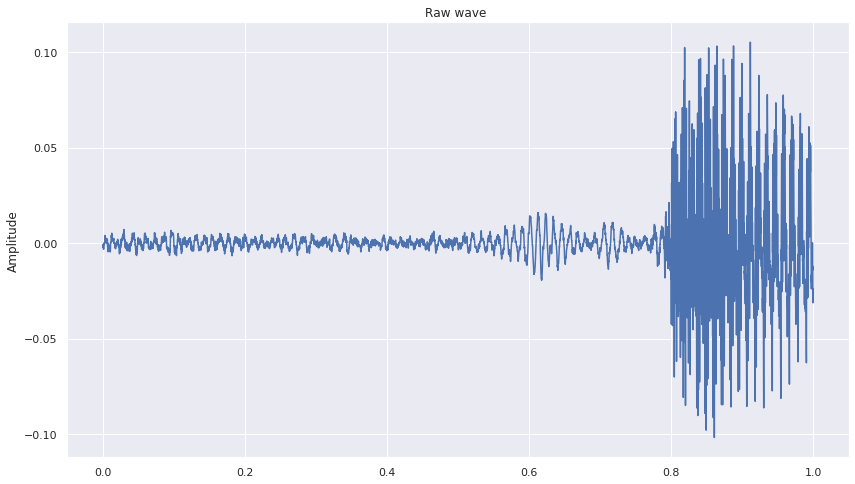

In [29]:
# Example 
aa = AudioAugmentation()
# Read cat sound
data = aa.read_audio_file("591d32f3_nohash_0.wav")
aa.plot_time_series(data)
# Adding noise to sound
data_noise = aa.add_noise(data)

In [0]:
##### Start data augmentation
path_to_wav = './speech_commands/'
directories_speech_commands = os.listdir(path_to_wav)
directories_speech_commands = [x for x in directories_speech_commands if os.path.isdir(os.path.join(path_to_wav,x))]
directories_speech_commands = [x for x in directories_speech_commands if x != '_background_noise_']
label_set = directories_speech_commands

aa = AudioAugmentation()
for root, dirs, files in os.walk("speech_commands"):

    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.split("/")[-1]
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root, filename)
        partial_path = '/'.join([command, filename])
        print('start')
        train = aa.read_audio_file(full_name)
        train_noise = aa.add_noise(train)
        train_wavs.append(train_noise)
        train_labels.append(label)


In [0]:
# Training on the augmented dataset
## Feature extraction phase
best_lower = 100
best_upper = 8000
framerate=16000
wlen = 0.02 # changed the default value
n_epochs = 50
best_ncep = 9
# Best mfcc so far
best_mfcc = spectral.Spectral(nfilt=20,ncep=best_ncep,
                    do_dct=True,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=wlen,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=True)

feature_function = best_mfcc
start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time() 
print("Time to output features: " + str(end-start))


train_feats2 = train_feats.reshape(train_feats.shape[0],-1,1)
valid_feats2 = valid_feats.reshape(valid_feats.shape[0],-1,1)
test_feats2 = test_feats.reshape(test_feats.shape[0],-1,1)


In [40]:
### Training phase
all_labels = train_labels + valid_labels+ test_labels 
all_labels_cat = to_categorical(all_labels,nb_of_categories)

train_labels_cat = all_labels_cat[:len(train_labels)]
best_model,mcp = load_base_model() 
start = time.time()
history= best_model.fit(train_feats2,train_labels_cat,validation_data=(valid_feats2,valid_labels_cat),epochs=n_epochs,batch_size=32,callbacks=[mcp])
print('NN network score',best_model.evaluate(test_feats2, test_labels_cat))
end = time.time()
print("Training time: " + str(end-start))


Train on 32592 samples, validate on 1000 samples
Epoch 1/50
32592/32592 [==============================] - 30s 925us/step - loss: 2.5304 - acc: 0.3001 - val_loss: 2.1521 - val_acc: 0.3620
Epoch 2/50
32592/32592 [==============================] - 13s 407us/step - loss: 1.7209 - acc: 0.5059 - val_loss: 1.6720 - val_acc: 0.4780
Epoch 3/50
32592/32592 [==============================] - 14s 421us/step - loss: 1.4507 - acc: 0.5806 - val_loss: 1.3872 - val_acc: 0.5660
Epoch 4/50
32592/32592 [==============================] - 13s 403us/step - loss: 1.3000 - acc: 0.6252 - val_loss: 1.2690 - val_acc: 0.6390
Epoch 5/50
32592/32592 [==============================] - 13s 411us/step - loss: 1.1921 - acc: 0.6547 - val_loss: 1.1827 - val_acc: 0.6850
Epoch 6/50
32592/32592 [==============================] - 13s 404us/step - loss: 1.1174 - acc: 0.6741 - val_loss: 1.0391 - val_acc: 0.7270
Epoch 7/50
32592/32592 [==============================] - 13s 405us/step - loss: 1.0597 - acc: 0.6923 - val_loss: 1.0

## **Question 1.5:** 

Study the influence on the performance of the model choices and their hyper-parameters. You can add other models of your choice. Focus on one type of features and one of the configurations based on previous questions. Comment your results.

In [0]:
best_lower = 100
best_upper = 8000
framerate=16000
wlen = 0.02 # changed the default value
n_epochs = 50
best_ncep = 9

In [0]:
best_mfcc = spectral.Spectral(nfilt=20,ncep=best_ncep,
                    do_dct=True,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=wlen,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=True)

feature_function = best_mfcc
start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time() 
print("Time to output features: " + str(end-start))


train_feats2 = train_feats.reshape(train_feats.shape[0],-1,1)
valid_feats2 = valid_feats.reshape(valid_feats.shape[0],-1,1)
test_feats2 = test_feats.reshape(test_feats.shape[0],-1,1)

train_feats_scaled = preprocessing.scale(train_feats)
valid_feats_scaled = preprocessing.scale(valid_feats)
test_feats_scaled = preprocessing.scale(test_feats)

Time to output features: 292.1472010612488


In [0]:
### We will try 2 other along with the previous CNN structure

# Logistic regression unscaled: 
from sklearn.model_selection import GridSearchCV

logreg = sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', n_jobs=4,
                                            learning_rate='optimal', early_stopping=True, tol=1,
                                            validation_fraction=0.3, n_iter_no_change=5)

alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]
clf = GridSearchCV(estimator=logreg, param_grid=dict(alpha=alphas),
                   n_jobs=4, scoring='accuracy', cv=3)


print('start training')
start = time.time()
clf.fit(train_feats, train_labels)
end = time.time()
print("Training time: " + str(end-start))
print("Best hyperparameter:", clf.best_estimator_.alpha)
print("Accuracy on test set " + str(100*clf.score(test_feats, test_labels)) + "%")
print("Accuracy on valid set " + str(100*clf.score(valid_feats, valid_labels)) + "%")


start training
Training time: 322.9763731956482
Best hyperparameter: 0.0001
Accuracy on test set 28.9%
Accuracy on valid set 28.299999999999997%


In [0]:
# Logistic regression scaled: 
logreg2 = sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', n_jobs=4,
                                            learning_rate='optimal', early_stopping=True, tol=1,
                                            validation_fraction=0.3, n_iter_no_change=5)

clf2 = GridSearchCV(estimator=logreg2, param_grid=dict(alpha=alphas),
                   n_jobs=4, scoring='accuracy', cv=3)


print('start training')
start = time.time()
clf2.fit(train_feats_scaled, train_labels)
end = time.time()
print("Training time: " + str(end-start))
print("Best hyperparameter:", clf2.best_estimator_.alpha)
print("Accuracy on test set " + str(100*clf2.score(test_feats_scaled, test_labels)) + "%")
print("Accuracy on valid set " + str(100*clf2.score(valid_feats_scaled, valid_labels)) + "%")


start training
Training time: 363.37422943115234
Best hyperparameter: 0.0001
Accuracy on test set 9.5%
Accuracy on valid set 13.0%


In [0]:
# Try Lightgbm
from lightgbm import LGBMClassifier

In [0]:
# Unscaled LightGBM

lgbm = LGBMClassifier(max_depth=6,n_estimators=300,reg_lambda=1)

start = time.time()
lgbm.fit(train_feats,train_labels,verbose=False,early_stopping_rounds=30,eval_metric='multi_logloss',eval_set=[(train_feats,train_labels),(valid_feats,valid_labels)])
end = time.time()
print("Training time: " + str(end-start))
print("Accuracy on test set " + str(100*lgbm.score(test_feats, test_labels)) + "%")
print("Accuracy on valid set " + str(100*lgbm.score(valid_feats, valid_labels)) + "%")


Training time: 2414.819356203079
Accuracy on test set 56.2%
Accuracy on valid set 58.599999999999994%


In [0]:
# Scaled LightGBM
lgbm2 = LGBMClassifier(max_depth=6,n_estimators=300,reg_lambda=1)

start = time.time()
lgbm2.fit(train_feats_scaled,train_labels,verbose=False,early_stopping_rounds=30,eval_metric='multi_logloss',eval_set=[(train_feats_scaled,train_labels),(valid_feats_scaled,valid_labels)])
end = time.time()
print("Training time: " + str(end-start))
print("Accuracy on test set " + str(100*lgbm2.score(test_feats_scaled, test_labels)) + "%")
print("Accuracy on valid set " + str(100*lgbm2.score(valid_feats_scaled, valid_labels)) + "%")


Training time: 2520.814103603363
Accuracy on test set 45.7%
Accuracy on valid set 48.6%


## **Question 1.6:**

Based on the study on the validation set for the different precedent questions, report the performance for the test set for your best configuration. Feel free to run more experiments. Comment on the results (best model, best features, pre-processing). Analyze the classes that are the most difficult to recognize. You can try to push the performance and justify these new choices.

In [0]:
best_lower = 100
best_upper = 8000
framerate=16000
wlen = 0.02 # changed the default value
n_epochs = 50
best_ncep = 9
# We will not use normalization as it dos not improve our model

In [0]:
best_mfcc = spectral.Spectral(nfilt=20,ncep=best_ncep,
                    do_dct=True,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=wlen,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=True)

In [0]:
## Get the best model
    
train_feats2 = train_feats.reshape(train_feats.shape[0],-1,1)
valid_feats2 = valid_feats.reshape(valid_feats.shape[0],-1,1)
test_feats2 = test_feats.reshape(test_feats.shape[0],-1,1)

best_model,mcp = load_base_model()
start = time.time()
history= best_model.fit(train_feats2,train_labels_cat,validation_data=(valid_feats2,valid_labels_cat),epochs=n_epochs,batch_size=32,callbacks=[mcp])
print('NN network score',best_model.evaluate(test_feats2, test_labels_cat))
end = time.time()
print("Training time: " + str(end-start))



Train on 30000 samples, validate on 1000 samples
Epoch 1/50
30000/30000 [==============================] - 29s 980us/step - loss: 2.7707 - acc: 0.2209 - val_loss: 2.1234 - val_acc: 0.3410
Epoch 2/50
30000/30000 [==============================] - 14s 481us/step - loss: 1.9077 - acc: 0.4491 - val_loss: 1.6848 - val_acc: 0.4990
Epoch 3/50
30000/30000 [==============================] - 14s 483us/step - loss: 1.5802 - acc: 0.5383 - val_loss: 1.3199 - val_acc: 0.6370
Epoch 4/50
30000/30000 [==============================] - 14s 479us/step - loss: 1.4245 - acc: 0.5863 - val_loss: 1.2131 - val_acc: 0.6580
Epoch 5/50
30000/30000 [==============================] - 15s 486us/step - loss: 1.3261 - acc: 0.6163 - val_loss: 1.1569 - val_acc: 0.6580
Epoch 6/50
30000/30000 [==============================] - 14s 481us/step - loss: 1.2577 - acc: 0.6316 - val_loss: 1.1889 - val_acc: 0.6640
Epoch 7/50
30000/30000 [==============================] - 15s 492us/step - loss: 1.1926 - acc: 0.6494 - val_loss: 1.1

In [0]:
# Save the best model so far
import pickle
filename = 'best_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

## **Question 2.1**:

Can you point which line in the code above approximated the prior probability of each word $W_i$ to be equal? 

In [0]:
### Please check the answer pdf


## **Question 2.2**:

 Is it possible that WER<0? and WER>100? 

In [0]:
### Please check the answer pdf

In [0]:
!wget https://raw.githubusercontent.com/Rachine/Rachine.github.io/master/data/train_sequence_list.txt 
!wget https://raw.githubusercontent.com/Rachine/Rachine.github.io/master/data/test_sequence_list.txt 


path_to_wavs = '/content/speech_commands/'
train_sequence_list = [ast.literal_eval(ex) for ex in txt2list('/content/train_sequence_list.txt') ]
test_sequence_list = [ast.literal_eval(ex) for ex in txt2list('/content/test_sequence_list.txt') ]

def generate_wav_from_list_sequence(generated_list_sequence): 
    wavs = np.array([])
    for command in generated_list_sequence[1:]:
        wav_name = os.path.join((path_to_wavs),command[1])
        sample_rate, signal = wav.read(wav_name)
        wavs = np.append(wavs,signal)
    return wavs


# Again warning do not forget to change your pad function according to your choice of input features
  
def generate_posteriors_from_list_sequence(generated_list_sequence, model_predict_proba_function, feature_func): 
    posteriors = []
    for command in generated_list_sequence[1:]:
        wav_name = os.path.join((path_to_wavs),command[1])
        sample_rate, signal = wav.read(wav_name)
        features_input = np.asarray(pad(transform_wavs([signal], feature_function)))
        features_input = features_input.reshape(features_input.shape[0],-1,1)
        posterior = model_predict_proba_function(features_input)
        posteriors.append(posterior)
    
    posteriors = np.array(posteriors).reshape(-1,len(label_set))
    return posteriors

example_sequence = train_sequence_list[10]
sequence_wav  = generate_wav_from_list_sequence(example_sequence)

IPython.display.Audio(sequence_wav, rate=16000)


--2020-02-16 12:31:28--  https://raw.githubusercontent.com/Rachine/Rachine.github.io/master/data/train_sequence_list.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1277360 (1.2M) [text/plain]
Saving to: ‘train_sequence_list.txt.1’

train_sequence_list 100%[===================>]   1.22M  --.-KB/s    in 0.1s    

2020-02-16 12:31:28 (12.1 MB/s) - ‘train_sequence_list.txt.1’ saved [1277360/1277360]

--2020-02-16 12:31:29--  https://raw.githubusercontent.com/Rachine/Rachine.github.io/master/data/test_sequence_list.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting 

### 1. Independent inputs
#### Greedy search

In [0]:
import pickle
filename = 'best_model.sav'
best_model = pickle.load(open(filename, 'rb'))

In [0]:
best_lower = 100
best_upper = 8000
framerate=16000
wlen = 0.02 # changed the default value
n_epochs = 50
best_ncep = 9
# We will not use normalization as it dos not improve our model

In [0]:
best_mfcc = spectral.Spectral(nfilt=20,ncep=best_ncep,
                    do_dct=True,
                    lowerf=best_lower,
                    upperf=best_upper,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=wlen,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=True)

['8f4c551f', ['go', 'go/8f4c551f_nohash_4.wav'], ['marvin', 'marvin/8f4c551f_nohash_0.wav'], ['one', 'one/8f4c551f_nohash_3.wav'], ['right', 'right/8f4c551f_nohash_0.wav'], ['stop', 'stop/8f4c551f_nohash_1.wav']]


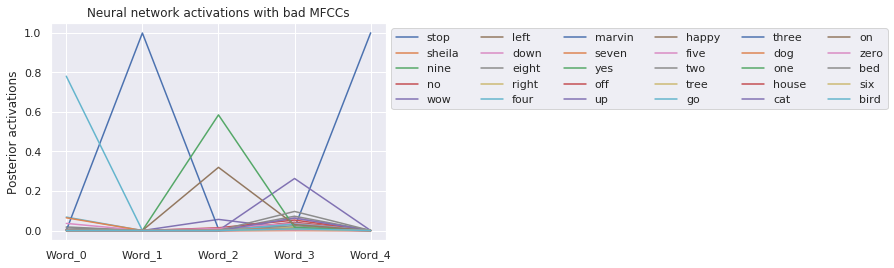

True sentence:  go marvin one right stop
Predicted sentence with greedy search:  go marvin one up stop
WER:  0.2


In [0]:
example_sequence = train_sequence_list[10]
print(example_sequence)
#example_sequence=np.array(example_sequence).reshape(np.array(example_sequence).shape[0],-1,1)
posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(example_sequence, best_model.predict_proba, best_mfcc))


list_plots = plt.plot(['Word_'+str(el) for el in range(posteriors_neural_mfcc.shape[0])],posteriors_neural_mfcc)
plt.legend(list_plots, label_set, loc="upper left", bbox_to_anchor=(1,1), ncol=6)
plt.ylabel('Posterior activations')
plt.title('Neural network activations with bad MFCCs')
plt.show()


def greedy_decoder(data):
  predicted_sequence = [np.argmax(s) for s in data]
  predicted_sequence = [label_set[el] for el in predicted_sequence]
  return predicted_sequence

def sequence_format_to_text(sentence):
  return [el[0] for el in sentence[1:]]

predicted_sequence = greedy_decoder(posteriors_neural_mfcc)
print('True sentence: ', ' '.join(sequence_format_to_text(example_sequence)))
print('Predicted sentence with greedy search: ', ' '.join(predicted_sequence))
print('WER: ',jiwer.wer(' '.join(sequence_format_to_text(example_sequence)),' '.join(predicted_sequence)))

## **Question 2.3**:
Can you detail the computations of the WER for the example above? 

In [0]:
#### Please refer to the PDF answer.pdf

In [0]:

# Evaluation of WER for the Greedy Search decoding

train_hypothesis = []
train_reference = []

# EVALUATION on the full train set takes too much time, so you should evaluate on a subset

for sentence in  np.random.choice(train_sequence_list, 300, replace=False):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence,best_model.predict_proba, best_mfcc))
  predicted_sequence = greedy_decoder(posteriors_neural_mfcc)
  train_hypothesis.append(' '.join(predicted_sequence))
  train_reference.append(' '.join(sequence_format_to_text(sentence)))
  
  
test_hypothesis = []
test_reference = []
for idx, sentence in enumerate(test_sequence_list):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence, best_model.predict_proba, best_mfcc))
  predicted_sequence = greedy_decoder(posteriors_neural_mfcc)
  test_hypothesis.append(' '.join(predicted_sequence))
  test_reference.append(' '.join(sequence_format_to_text(sentence)))

  
start = time.time()
print('Subset Train WER: ',jiwer.wer(train_reference, train_hypothesis))
print('Test WER: ',jiwer.wer(test_reference, test_hypothesis))

end = time.time()

print("Evaluation time: " + str(end-start))


Subset Train WER:  0.259768849752339
Test WER:  0.25
Evaluation time: 52.368205547332764


### Inject Language Models in the path scoring

## **Question 2.4**:

Write the Bigram approximation formula of the language model

In [0]:
def bigram(corpus,label_set):
    n = len(label_set)
    p = len(corpus)
    transition_matrix = np.ones((n,n))  #Initialize with a matrix of ones: Laplace smoothing
    words = {word:i for (i,word) in enumerate(label_set)}
    sequences = [[l[0] for l in seq[1:]] for seq in corpus]
    bigrams = [(seq[i], seq[i+1]) for seq in sequences for i in range(len(seq)-1)]
    for (w1,w2) in bigrams:
      transition_matrix[words[w1], words[w2]] += 1 #Increment count
    for i in range(n):
      if np.sum(transition_matrix[i,:]) > 0:
          transition_matrix[i,:] /= (1.0*np.sum(transition_matrix[i,:]) + 1.0*p)  #Normalize to get probability
    return bigrams,transition_matrix

[('happy', 'tree'), ('tree', 'on'), ('on', 'happy'), ('happy', 'tree'), ('tree', 'no'), ('cat', 'on'), ('on', 'bird'), ('bird', 'no'), ('go', 'sheila'), ('sheila', 'two'), ('two', 'up'), ('up', 'stop'), ('happy', 'tree'), ('tree', 'on'), ('on', 'happy'), ('happy', 'tree'), ('tree', 'wow'), ('happy', 'cat'), ('cat', 'on'), ('on', 'happy'), ('happy', 'tree'), ('tree', 'wow'), ('cat', 'on'), ('on', 'bird'), ('bird', 'yes'), ('happy', 'bird'), ('bird', 'on'), ('on', 'happy'), ('happy', 'house'), ('house', 'wow'), ('happy', 'cat'), ('cat', 'on'), ('on', 'happy'), ('happy', 'tree'), ('tree', 'yes'), ('go', 'sheila'), ('sheila', 'two'), ('two', 'up'), ('up', 'one'), ('one', 'right'), ('right', 'two'), ('two', 'right'), ('right', 'stop'), ('go', 'sheila'), ('sheila', 'two'), ('two', 'down'), ('down', 'two'), ('two', 'left'), ('left', 'two'), ('two', 'left'), ('left', 'one'), ('one', 'left'), ('left', 'stop'), ('go', 'marvin'), ('marvin', 'one'), ('one', 'right'), ('right', 'stop'), ('go', 'mar

Text(0.5, 66.5, '2nd Word')

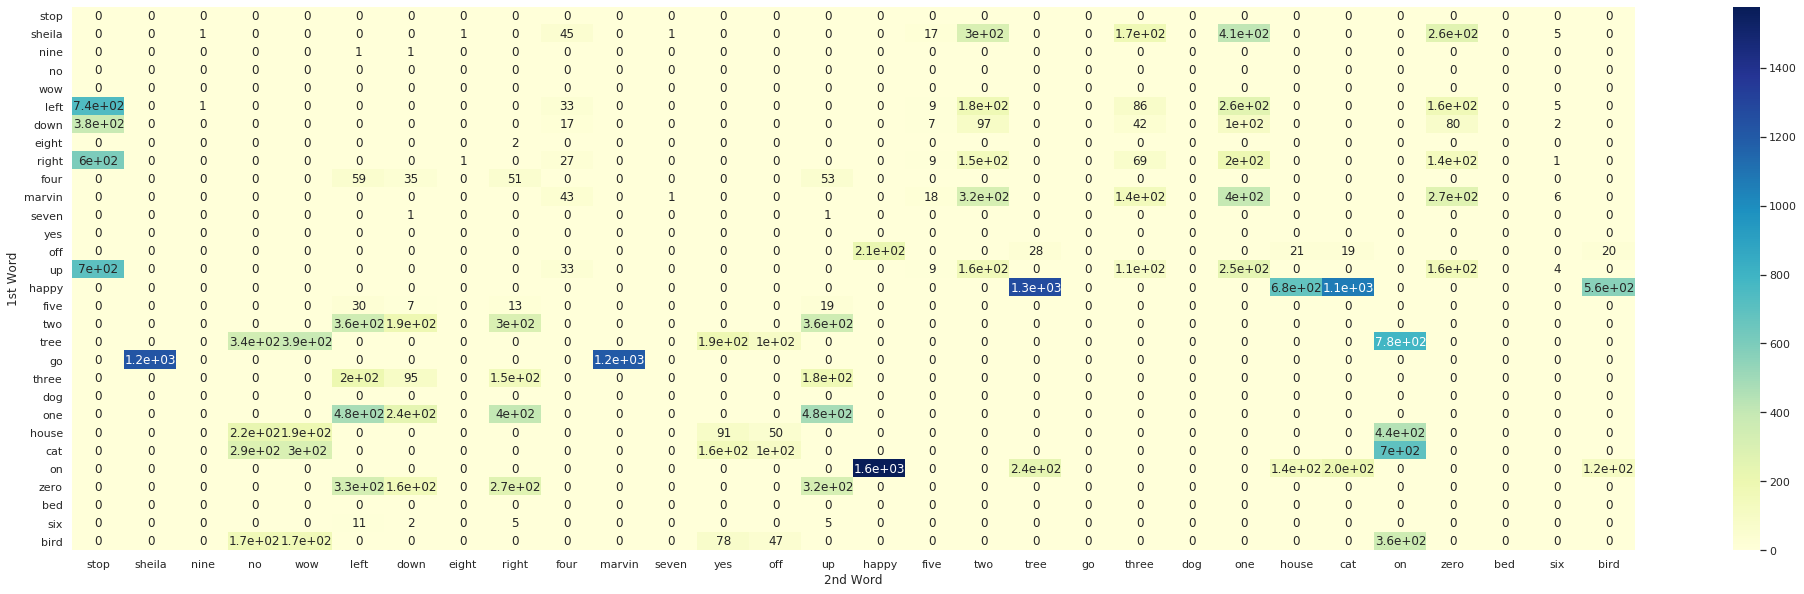

In [0]:
import pandas as pd
import seaborn as sns; sns.set()
from collections import Counter
# Define Bigram matrix
def correlation_mtx(ngrams,label_set):
    #label_set =['</s>']+  label_set 
    counter_ngrams = Counter(ngrams)
    n = len(label_set)

    corr = pd.DataFrame(np.zeros((n,n)),index = label_set, columns = label_set) 
    print(ngrams)
    for (w1,w2) in counter_ngrams.keys():
        corr.loc[(w1,w2)] = int(counter_ngrams[(w1,w2)])
    return corr

# Plot Heatmap
bigrams,transition_matrix = bigram(train_sequence_list,label_set)
corr = correlation_mtx(bigrams,label_set)
f, ax = plt.subplots(figsize=(35, 10))
ax = sns.heatmap(corr,annot=True,cmap="YlGnBu")
plt.ylabel('1st Word')
plt.xlabel('2nd Word')

## **Question 2.5**:

Explain briefly your implementation choices

In [0]:
#### Please refer to the PDF answer.pdf

## **Question 2.6**: 

What are the advantages and drawbacks to increase the N ?

In [0]:
#### Please refer to the PDF answer.pdf

**Beam-Search**
Based on your transition matrix, your best discriminator, implement the Beam-Search algorithm. 

## **Question 2.7**: 

What are the time and memory complexity of the Beam search algorithm?

In [0]:
#### Please refer to the answer PDF for this question

In [0]:
## example
# Beam Search decoder
def Beam_search_decoder(data, transition_matrix, label_set,beam_size=5):
    #label_set =['</s>']+  label_set 
    sequences = [([i], transition_matrix[0,i]) 
                 for i in np.argpartition(transition_matrix[0,:], -beam_size)[-beam_size:]]
    n = len(data)
    for i in range(1,n):
        possible_candidates = []  
        for (seq, score) in sequences:
            
            scores = score *data[i]*transition_matrix[seq[-1]] 

            possible_candidates = possible_candidates + [(seq+[j], scores[j]) for j in range(data.shape[1])]
       
        sequences = sorted(possible_candidates, key=lambda tup:tup[1],reverse=True)[:beam_size]      
  
    sequence = sequences[ np.argmax([score for (seq, score) in sequences])][0]
    predicted_sequence = [label_set[el] for el in sequence]
    return predicted_sequence

**Dynamic progamming with the Viterbi algorithm**
## **Question 2.8**: 

What is the relationship between the probability to be in state  𝑗  at step  𝑘 , and the probabilities to be in state  𝑗′  at step  𝑘−1 ? What are the final time and memory complexity of the Viterbi algorithm?

Based on your transition matrix, your best discriminator, implement now the Viterbi algorithm.


In [0]:
# Viterbi decoder

def viterbi_decoder(data,transition_matrix,label_set):
    ## X = data : corpus
    n_seq,n_labels = data.shape
    S = np.zeros((n_labels ,n_seq)).astype(np.int64)
    P = np.zeros((n_labels ,n_seq)) # Probability of state j (word j) at step k
    sequence = np.zeros((n_seq,)).astype(np.int64)
    # intialize for the first word
    P[:,0] = 1./n_seq *data[0,:]

    for k in range(1,n_seq):
        for j in range(n_labels ):
            new_prob = np.multiply(P[:,k-1],transition_matrix[:,j])
            S[j,k] = np.argmax(new_prob)
            P[j,k] = new_prob[S[j,k]]* data[k,j]

    sequence[n_seq-1] = np.argmax(P[:,n_seq-1])

    for k in reversed(range(n_seq-1)):
        sequence[k] = S[(sequence[k+1]),k+1]
      

    predicted_sequence = [label_set[el] for el in sequence]
    return predicted_sequence

# Results for decoding algorithms

In your report for this practical work, you should examine your experiments: the different strategies with  the different implementation choices you made and the various parameters. 




## **Question 2.9** 

Compare the performance of the Greedy, Beam-search and Viterbi algorithm: In theory which one is the best and why? What are the results in practice? Comment on the results 

In [0]:
example_sequence = train_sequence_list[10]

posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(example_sequence, best_model.predict_proba, best_mfcc))
data = posteriors_neural_mfcc 

bigrams,transition_matrix = bigram(train_sequence_list,label_set)
predicted_sequence_greedy = greedy_decoder(data)
predicted_sequence_beam = Beam_search_decoder(data, transition_matrix,label_set, beam_size=5)
predicted_sequence_viterbi = viterbi_decoder(data,transition_matrix,label_set)

print('True sentence: ', ' '.join(sequence_format_to_text(example_sequence)))
print('Predicted sentence with greedy search: ', ' '.join(predicted_sequence_greedy))
print('WER greedy: ',jiwer.wer(' '.join(sequence_format_to_text(example_sequence)),' '.join(predicted_sequence_greedy)))
print('Predicted sentence with beam search: ', ' '.join(predicted_sequence_beam))
print('WER beam: ',jiwer.wer(' '.join(sequence_format_to_text(example_sequence)),' '.join(predicted_sequence_beam)))
print('Predicted sentence with viterbi search: ', ' '.join(predicted_sequence_viterbi))
print('WER viterbi: ',jiwer.wer(' '.join(sequence_format_to_text(example_sequence)),' '.join(predicted_sequence_viterbi)))
 

True sentence:  go marvin one right stop
Predicted sentence with greedy search:  go marvin one up stop
WER greedy:  0.2
Predicted sentence with beam search:  seven marvin one up stop
WER beam:  0.4
Predicted sentence with viterbi search:  go marvin one up stop
WER viterbi:  0.2


In [0]:

# Evaluation of WER for the Greedy Search decoding

train_hypothesis = []
train_reference = []

# EVALUATION on the full train set takes too much time, so you should evaluate on a subset

for sentence in  np.random.choice(train_sequence_list, 300, replace=False):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence,best_model.predict_proba, best_mfcc))
  predicted_sequence = greedy_decoder(posteriors_neural_mfcc)
  train_hypothesis.append(' '.join(predicted_sequence))
  train_reference.append(' '.join(sequence_format_to_text(sentence)))
  
  
test_hypothesis = []
test_reference = []
for idx, sentence in enumerate(test_sequence_list):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence, best_model.predict_proba, best_mfcc))
  predicted_sequence = greedy_decoder(posteriors_neural_mfcc)
  test_hypothesis.append(' '.join(predicted_sequence))
  test_reference.append(' '.join(sequence_format_to_text(sentence)))

  
start = time.time()
print('Subset Train WER greedy: ',jiwer.wer(train_reference, train_hypothesis))
print('Test WER greedy: ',jiwer.wer(test_reference, test_hypothesis))

end = time.time()

print("Evaluation time: " + str(end-start))


Subset Train WER greedy:  0.28169014084507044
Test WER greedy:  0.25
Evaluation time: 54.328161001205444


In [0]:

# Evaluation of WER for the Beam Search decoding

train_hypothesis = []
train_reference = []

# EVALUATION on the full train set takes too much time, so you should evaluate on a subset

for sentence in  np.random.choice(train_sequence_list, 300, replace=False):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence,best_model.predict_proba, best_mfcc))
  predicted_sequence = Beam_search_decoder(posteriors_neural_mfcc, transition_matrix, label_set,beam_size=5)
  train_hypothesis.append(' '.join(predicted_sequence))
  train_reference.append(' '.join(sequence_format_to_text(sentence)))
  
  
test_hypothesis = []
test_reference = []
for idx, sentence in enumerate(test_sequence_list):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence, best_model.predict_proba, best_mfcc))
  predicted_sequence = Beam_search_decoder(data, transition_matrix, label_set,beam_size=5)
  test_hypothesis.append(' '.join(predicted_sequence))
  test_reference.append(' '.join(sequence_format_to_text(sentence)))

  
start = time.time()
print('Subset Train WER beam: ',jiwer.wer(train_reference, train_hypothesis))
print('Test WER beam: ',jiwer.wer(test_reference, test_hypothesis))

end = time.time()

print("Evaluation time: " + str(end-start))


Subset Train WER beam:  0.2902506963788301
Test WER beam:  0.795751633986928
Evaluation time: 44.76161861419678


In [0]:

# Evaluation of WER for the Beam Search decoding

train_hypothesis = []
train_reference = []

# EVALUATION on the full train set takes too much time, so you should evaluate on a subset

for sentence in  np.random.choice(train_sequence_list, 300, replace=False):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence,best_model.predict_proba, best_mfcc))
  predicted_sequence = viterbi_decoder(posteriors_neural_mfcc,transition_matrix,label_set)
  train_hypothesis.append(' '.join(predicted_sequence))
  train_reference.append(' '.join(sequence_format_to_text(sentence)))
  
  
test_hypothesis = []
test_reference = []
for idx, sentence in enumerate(test_sequence_list):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence, best_model.predict_proba, best_mfcc))
  predicted_sequence = viterbi_decoder(posteriors_neural_mfcc,transition_matrix,label_set)
  test_hypothesis.append(' '.join(predicted_sequence))
  test_reference.append(' '.join(sequence_format_to_text(sentence)))

  
start = time.time()
print('Subset Train WER viterbi: ',jiwer.wer(train_reference, train_hypothesis))
print('Test WER viterbi: ',jiwer.wer(test_reference, test_hypothesis))

end = time.time()

print("Evaluation time: " + str(end-start))


Subset Train WER viterbi:  0.09757412398921833
Test WER viterbi:  0.08333333333333333
Evaluation time: 56.4477014541626



##**Question 2.10**: 

Can you spot systematic errors due to language model you derived from the training sequences? Provide us some of these errors.


In [0]:
#### Please refer to the PDF answer.pdf for theoretical answers


## **Question 2.11**:

Can you implement some backoff strategies to face rare seen words(or sequence of words)?  Can you implement some backoff strategies to face Out of Vocabulary (OOV) words? Does it improve your Word Error Rate? 



--> **One strategy i used is to add smoothing while calculationg the bigram function.**


In [0]:
### Please refer to the PDF answer.pdf for theoretical answers


In [0]:
# Viterbi and bigrams without smoothing:

### Bigram without any smoothing
def bigram2(corpus,label_set):
    n = len(label_set)
    p = len(corpus)
    transition_matrix = np.zeros((n,n))  #Initialize with a matrix of ones: Laplace smoothing
    words = {word:i for (i,word) in enumerate(label_set)}
    sequences = [[l[0] for l in seq[1:]] for seq in corpus]
    bigrams = [(seq[i], seq[i+1]) for seq in sequences for i in range(len(seq)-1)]
    for (w1,w2) in bigrams:
      transition_matrix[words[w1], words[w2]] += 1 #Increment count
    for i in range(n):
      if np.sum(transition_matrix[i,:]) > 0:
          transition_matrix[i,:] /= (1.0*np.sum(transition_matrix[i,:]))  #Normalize to get probability
    return bigrams,transition_matrix

In [0]:
print('Without smoothing')
# Evaluation of WER for the Beam Search decoding

train_hypothesis = []
train_reference = []
bigrams,transition_matrix = bigram2(train_sequence_list,label_set)
# EVALUATION on the full train set takes too much time, so you should evaluate on a subset

for sentence in  np.random.choice(train_sequence_list, 300, replace=False):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence,best_model.predict_proba, best_mfcc))
  predicted_sequence = viterbi_decoder(posteriors_neural_mfcc,transition_matrix,label_set)
  train_hypothesis.append(' '.join(predicted_sequence))
  train_reference.append(' '.join(sequence_format_to_text(sentence)))
  
  
test_hypothesis = []
test_reference = []
for idx, sentence in enumerate(test_sequence_list):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence, best_model.predict_proba, best_mfcc))
  predicted_sequence = viterbi_decoder(posteriors_neural_mfcc,transition_matrix,label_set)
  test_hypothesis.append(' '.join(predicted_sequence))
  test_reference.append(' '.join(sequence_format_to_text(sentence)))

  
start = time.time()
print('Subset Train WER viterbi: ',jiwer.wer(train_reference, train_hypothesis))
print('Test WER viterbi: ',jiwer.wer(test_reference, test_hypothesis))

end = time.time()

print("Evaluation time: " + str(end-start))


Without smoothing
Subset Train WER viterbi:  0.08166576527852894
Test WER viterbi:  0.07352941176470588
Evaluation time: 53.2502224445343


In [0]:
print('With smoothing')
# Evaluation of WER for the Beam Search decoding

train_hypothesis = []
train_reference = []
bigrams,transition_matrix = bigram(train_sequence_list,label_set)
# EVALUATION on the full train set takes too much time, so you should evaluate on a subset

for sentence in  np.random.choice(train_sequence_list, 300, replace=False):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence,best_model.predict_proba, best_mfcc))
  predicted_sequence = viterbi_decoder(posteriors_neural_mfcc,transition_matrix,label_set)
  train_hypothesis.append(' '.join(predicted_sequence))
  train_reference.append(' '.join(sequence_format_to_text(sentence)))
  
  
test_hypothesis = []
test_reference = []
for idx, sentence in enumerate(test_sequence_list):
  posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence, best_model.predict_proba, best_mfcc))
  predicted_sequence = viterbi_decoder(posteriors_neural_mfcc,transition_matrix,label_set)
  test_hypothesis.append(' '.join(predicted_sequence))
  test_reference.append(' '.join(sequence_format_to_text(sentence)))

  
start = time.time()
print('Subset Train WER viterbi: ',jiwer.wer(train_reference, train_hypothesis))
print('Test WER viterbi: ',jiwer.wer(test_reference, test_hypothesis))

end = time.time()

print("Evaluation time: " + str(end-start))


With smoothing
Subset Train WER viterbi:  0.08797327394209355
Test WER viterbi:  0.08333333333333333
Evaluation time: 52.45863127708435


## **Question 2.12**:  

How would you optimize jointly an acoustic model and language model? 